# World Data League 2021

## Introduction
TODO: Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development

### 1. Data exploration

Inspect available datasets and merge them:
- **senior_tim_df** : Database with the daily average of senior citizens travelling on road network links based on one year, between April 2019 and March 2020.
- **bus_routes_df**: Identification of road segments that are part of the different bus routes.

In [ ]:
!pip install -qq pandas_summary
!pip install --upgrade -qq plotly

In [2]:
# imports and configuration
#from pandas_summary import DataFrameSummary
import numpy as np
import json
#from pandas_summary import DataFrameSummary
import plotly.express as px
import seaborn as sns

import pandas as pd
import os
import requests
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *
import warnings



plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (5, 7)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})


pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [3]:
# read data
bus_routes_df = pd.read_csv("https://wdl-data.fra1.digitaloceanspaces.com/pse/BusRoutes.txt", sep="|", encoding= 'unicode_escape')

# traffic intensity model
senior_tim_df = pd.read_csv("https://wdl-data.fra1.digitaloceanspaces.com/pse/Senior_TIM_v1.txt", sep="|", encoding= 'unicode_escape')

In [4]:
display(senior_tim_df.head())
senior_tim_df.shape

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681
1,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296
2,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647
3,80216810,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,233.203
4,80216812,R1 - AM Lisboa,Lisboa,Lisboa,261.606


(121053, 5)

In [ ]:
display(bus_routes_df.head())
bus_routes_df.shape

,IDRoute,linkid
0,1,537277300
1,1,537277673
2,1,537277754
3,1,537277777
4,1,537277795


(48312, 2)

In [ ]:
# value counts per region, district and county of origin
for r in ['Region_of_Origin', 'District_of_Origin', 'County_of_Origin']:
    print(senior_tim_df[r].value_counts())
    print()

R1 - AM Lisboa    102889
R2 - AM Porto      18164
Name: Region_of_Origin, dtype: int64

Lisboa     80784
Setúbal    22105
Porto      17927
Aveiro       237
Name: District_of_Origin, dtype: int64

Oeiras                  16692
Lisboa                  15329
Vila Franca de Xira     14289
Sintra                  11443
Maia                     9114
Odivelas                 8310
Barreiro                 7640
Cascais                  5565
Seixal                   5472
Porto                    4370
Mafra                    4182
Gondomar                 4010
Amadora                  3334
Palmela                  2759
Montijo                  2142
Loures                   1640
Setúbal                  1584
Almada                   1355
Sesimbra                 1102
Matosinhos                433
Santa Maria da Feira      237
Alcochete                  47
Moita                       4
Name: County_of_Origin, dtype: int64



In [5]:
# merge both dataframes together
total_df = senior_tim_df.merge(bus_routes_df, how='left', on='linkid')
senior_tim_df = total_df[['linkid', 'County_of_Origin', 'Average_Daily_SeniorPopulation_Travelling', 'IDRoute']]

### 2. Demand vs supply analysis

Analysis of the replationship between demand and supply of public transportation:
- **Demand**: Demand for transportation of the Senior Population, obtained from the field 'Average_Daily_SeniorPopulation_Travelling'
- **Supply**: Supply of public transportation (limited in this case to bus routes), obtained by the field 'IDRoute'

In [14]:
# create supply vs demand dataframe

supply = pd.DataFrame(total_df.groupby('County_of_Origin').first()['Average_Daily_SeniorPopulation_Travelling']).reset_index()
demand = pd.DataFrame(total_df.groupby('County_of_Origin').nunique()['IDRoute']).reset_index()
supply_demand = supply.merge(demand, on='County_of_Origin')
supply_demand['supply/demand'] = (supply_demand['IDRoute'] / supply_demand['Average_Daily_SeniorPopulation_Travelling'])
supply_demand = supply_demand.sort_values(by='supply/demand', axis=0).reset_index()
supply_demand.head()

,index,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
0,11,Moita,60.830,0,0.000
1,15,Palmela,7688.296,68,0.009
2,5,Gondomar,5465.166,95,0.017
3,0,Alcochete,408.105,8,0.020
4,12,Montijo,520.097,15,0.029


### 3. Geospatial representation of data

Using Google Geocoding API and Folium geographic visualization library, add the coordinates of each county and represent the "Average Daily Senior Population Travelling" versus the "Number of Bus Routes" available. This way we can graphically see where the demand exceeds supply and viceversa.

In [ ]:
# insert your Google Geocoding API Google Key (deleted from notebook for privacy purposes)
os.environ['GOOGLE_API_KEY'] = ''

In [ ]:
# define function to get coordinates from any address

def get_address(address):
    """Gets lat and long coordinates from any address.

    Parameters
    ----------
    address : str

    Returns
    -------
    lat: float
    lon: float
    """
    google_key = os.getenv("GOOGLE_API_KEY")
    address = address.replace(' ', '+')
    url = "https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={google_key}"\
              .format(address=address, google_key=google_key)
    data = [(requests.get(url)).json()]
    lat, lon = data[0]['results'][0]['geometry']['location'].values()
    return lat, lon

address = 'Oeiras'
get_address(address)

(38.69686069999999, -9.314601399999999)

In [16]:
# create dataframe with the coordinates of all the unique counties
unique_counties = pd.DataFrame(senior_tim_df['County_of_Origin'].unique(), columns=['County'])
unique_counties['coords'] = unique_counties['County'].apply(lambda address: get_address(address))


# merge unique counties with supply/demand to add the coordinates
supply_demand.rename(columns={'County_of_Origin': 'County'}, inplace=True)
supply_demand = supply_demand.merge(unique_counties, on='County')
supply_demand.head()

,index,County,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
0,11,Moita,60.830,0,0.000
1,15,Palmela,7688.296,68,0.009
2,5,Gondomar,5465.166,95,0.017
3,0,Alcochete,408.105,8,0.020
4,12,Montijo,520.097,15,0.029


In [17]:
# add coordinates to the merged total dataframe
total_df = senior_tim_df.merge(unique_counties, how='left', left_on='County_of_Origin', right_on='County')

In [ ]:
# define function to plot the map in Folium

def create_folium(supply_demand_df, coords, optimal_divisor_supply):
    """Plots a map with circles representing the demand (red) 
    and supply (blue) for public transportation so that they 
    can be compared by size.

    Parameters
    ----------
    supply_demand_df : DataFrame
        County level supply/demand aggregated 
        dataframe containing the following rows:
        - County
        - coords
        - Average_Daily_SeniorPopulation_Travelling (aggregated by sum)
        - IDRoute (aggregated by count)
    
    coords: tuple
        Central coordinates of the map

    optimal_divisor_supply: float
        number so that the county with optimal coverage of demand by supply
        has the same size circle for demand and supply

    Returns
    -------
    map_folium: folium.folium.Map
    """
    map_folium = folium.Map(coords, width=700, height=700, zoom_start=10)
    for index, row in supply_demand_df.iterrows():
        folium.Circle(location=row['coords'],
                      popup=row['County'],
                      radius=float(row['Average_Daily_SeniorPopulation_Travelling']),
                      color='crimson',
                      fill=True,
                      fill_color='crimson').add_to(map_folium)
        folium.Circle(location=row['coords'],
                      popup=row['County'],
                      radius=float(row['IDRoute']) / optimal_divisor_supply,
                      color='#2A89C6',
                      fill=True,
                      fill_color='#2A89C6').add_to(map_folium)
        
    return map_folium

In [ ]:
# define central coordinates for both Portuguese cities
lisbon_coords = [38.722284, -9.139323]
porto_coords = [41.157794, -8.629144]

### 4. Calculate optimal supply vs demand

Define which is the optimal ratio of supply vs demand, based on assumptions but necessary to extract conclusions .

In [51]:
# median supply / demand corresponds to Cascais, lets assume it as an optimal coverage of demand
optimal_supply_vs_demand = supply_demand[supply_demand['supply/demand']==supply_demand['supply/demand'].median()]
optimal_supply_vs_demand

,index,County,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
11,20,Setúbal,125.571,29,0.231


In [19]:
# calculate the optimal_radious_demand, which is needed to plot the relative supply vs demand
optimal_radious_demand = optimal_supply_vs_demand['Average_Daily_SeniorPopulation_Travelling']
optimal_divisor_supply = optimal_supply_vs_demand['IDRoute'] / optimal_radious_demand
print(optimal_divisor_supply)

11   0.231
dtype: float64


The determine an optimal number of supply and demand of bus routes, we calculated the ratio of number of available bus routes in a county and the number of seniors travelling. 

This gave us a supply/demand value that represents how well served a county is. The optimal was set to be median which we determined to be a value of 0.2. 

Using two extreme cases as an example, Moita is under-served, and Almada would be over-served. 

##### Moita
Moita has an estimated senior population of 3848 with a supply/demand value of 0. This is because Moita has no linkIDs with corresponding Bus routes. We consider Moita to be underserved. Mafra has an estimated senior population of 3920 which makes it a comparable county to Moita, and is much closer to the optimal for supply/demand. We conclude that for Moita to have a more optimal supply/demand value, we suggest a redistribution of public transportation resources from a location that is considered to be over-served. Moita requires a minimum number of bus routes of 12. 

##### Almada
Almada has an estimated senior population of 25218 and a supply/demand ratio of 1.96. 5 would be a more optimal total number of bus routes for Almada based on the number of people travelling to get it closer to the optimal value for supply/demand. 

In [56]:
supply_demand

,index,County,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
0,11,Moita,60.830,0,0.000
1,15,Palmela,7688.296,68,0.009
2,5,Gondomar,5465.166,95,0.017
3,0,Alcochete,408.105,8,0.020
4,12,Montijo,520.097,15,0.029
5,19,Sesimbra,545.930,24,0.044
6,10,Matosinhos,664.650,33,0.050
7,6,Lisboa,2013.681,132,0.066
8,17,Santa Maria da Feira,227.715,16,0.070
9,9,Maia,664.650,99,0.149


In [57]:
supply_demand.to_csv("suppdemand.csv", index=False)

In [20]:
# based on the optimal supply/vs demand (based on the median), define which counties are underserved and which ones are overserved
#. of public transportation

underserved_counties = supply_demand[supply_demand['supply/demand'] < float(optimal_supply_vs_demand['supply/demand'])]
overserved_counties = supply_demand[supply_demand['supply/demand'] > float(optimal_supply_vs_demand['supply/demand'])]

In [21]:
# underserved counties
underserved_counties

,index,County,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
0,11,Moita,60.830,0,0.000
1,15,Palmela,7688.296,68,0.009
2,5,Gondomar,5465.166,95,0.017
3,0,Alcochete,408.105,8,0.020
4,12,Montijo,520.097,15,0.029
5,19,Sesimbra,545.930,24,0.044
6,10,Matosinhos,664.650,33,0.050
7,6,Lisboa,2013.681,132,0.066
8,17,Santa Maria da Feira,227.715,16,0.070
9,9,Maia,664.650,99,0.149


In [22]:
# overserved_counties
overserved_counties

,index,County,Average_Daily_SeniorPopulation_Travelling,IDRoute,supply/demand
12,16,Porto,303.620,110,0.362
13,22,Vila Franca de Xira,233.203,100,0.429
14,4,Cascais,204.053,98,0.480
15,3,Barreiro,204.053,119,0.583
16,21,Sintra,181.380,107,0.590
17,14,Oeiras,220.647,152,0.689
18,2,Amadora,115.577,92,0.796
19,8,Mafra,88.905,81,0.911
20,18,Seixal,96.025,110,1.146
21,13,Odivelas,88.905,120,1.350


### 5. Plot maps

In this interactive maps, a graphical representation of the supply vs demand can be seen. Demand of senior population for transportation (in red) and supply for bus public transportation (in blue) is ploted. 

As described above, Lisbon is the city with 'optimal' / 'median' ratio of supply vs demand, that is why in the map, its circles are represented with the same size.

In [ ]:
# Lisbon map
create_folium(supply_demand, lisbon_coords, float(optimal_divisor_supply))

In [ ]:
# Porto map
create_folium(supply_demand, porto_coords, float(optimal_divisor_supply))

#### Load County Population

In [ ]:
# Scraped from https://www.citypopulation.de/en/portugal/cities/
# Load scraped data
#muni_df = pd.read_csv("/content/portugal_muni.csv")[["Name", "PopulationEstimate2015-12-31"]]

muni_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1Pd8LfO3a3UROOnd3ps5UPseiJeTbu2PE")[["Name", "PopulationEstimate2015-12-31"]]

# Normalize county names
muni_df["Name"][muni_df["Name"] == "Oeiras e São Julião da Barra, Paço de Arcos e Caxias"] = "Oeiras"
muni_df["Name"][muni_df["Name"] == "Cascais e Estoril"] = "Cascais"

## Remove format and convert population to numeric
muni_df["PopulationEstimate2015-12-31"].replace(',','', regex=True, inplace=True)
muni_df["PopulationEstimate2015-12-31"] = muni_df["PopulationEstimate2015-12-31"].apply(pd.to_numeric, errors='coerce')
muni_df["senior_prop"] = muni_df["PopulationEstimate2015-12-31"] * 0.218

In [ ]:
## Merge Population data with supply/demand
supply_demand_pop_df = supply_demand.merge(muni_df, how="left", left_on="County", right_on="Name")
supply_demand_pop_df['travel_senior_per_capita'] = supply_demand_pop_df['Average_Daily_SeniorPopulation_Travelling'] / supply_demand_pop_df['senior_prop']

#### Visualization

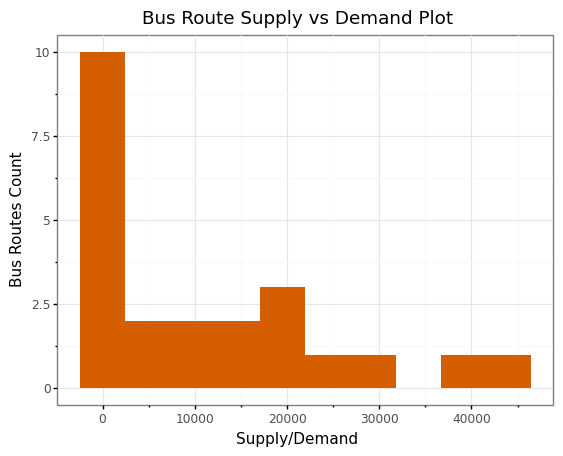

<ggplot: (8742572025053)>

In [ ]:
(
    ggplot(supply_demand_pop_df, aes(x='supply/demand'))
    + geom_histogram(bins=10, fill="#D55E00")
    + theme_bw() 
    + ggtitle("Bus Route Supply vs Demand Plot")
    + labs(y="Bus Routes Count", x ="Supply/Demand")
)

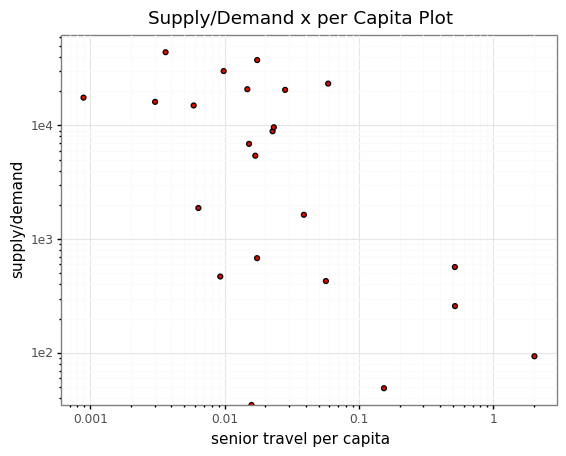

<ggplot: (8742562729605)>

In [ ]:
(
    ggplot(supply_demand_pop_df, aes(y='supply/demand', x='travel_senior_per_capita'))
    + geom_point(fill="#D50E00")
    + theme_bw() 
    + ggtitle("Supply/Demand x per Capita Plot")
    + labs(y="supply/demand", x ="senior travel per capita")
    + ylim(0, 1)
    + scale_x_log10()
    + scale_y_log10()
)

## LinkID Exploration

### Second viewpoint

We do a left join of bus routes on TIM dataset and observe that **62.45% of linkid don't have a IDRoute** associated with it.

We divide the whole dataset into two parts:
- The ones having IDRoute
- The ones without IDRoute


We perform analysis on these 2 datasets.

In [ ]:
!pip install -qq pandas_summary
!pip install --upgrade -qq plotly

     |████████████████████████████████| 13.2MB 305kB/s 


In [ ]:
import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np
import json

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (5, 7)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

In [ ]:
df_routes = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/BusRoutes.txt', 
                        delimiter = "|")
df_routes.head()

,IDRoute,linkid
0,1,537277300
1,1,537277673
2,1,537277754
3,1,537277777
4,1,537277795


In [ ]:
dfs_routes = DataFrameSummary(df_routes)
dfs_routes.columns_stats

,IDRoute,linkid
counts,48312,48312
uniques,166,19277
missing,0,0
missing_perc,0%,0%
types,numeric,numeric


In [ ]:
df_senior = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Senior_TIM_v1.txt', 
                        delimiter = "|", encoding='unicode_escape')
df_senior.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187
1,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396
2,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248
3,80216810,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,233.203075
4,80216812,R1 - AM Lisboa,Lisboa,Lisboa,261.606014


In [ ]:
left_df_senior = df_senior.merge(df_routes, on="linkid", how="left")
left_df_senior.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,8.0
1,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,85.0
2,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,8.0
3,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,85.0
4,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248,8.0


In [ ]:
# 62.45% of bus IDRoute are missing
dfs_left_df_senior = DataFrameSummary(left_df_senior)
dfs_left_df_senior.columns_stats

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
counts,160279,160279,160279,160279,160279,60181
uniques,75041,2,4,23,20176,164
missing,0,0,0,0,0,100098
missing_perc,0%,0%,0%,0%,0%,62.45%
types,numeric,bool,categorical,categorical,numeric,numeric


In [ ]:
na_routes = left_df_senior[left_df_senior['IDRoute'].isna()]
na_routes.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
14,80216828,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,346.731390,NaN
15,80216828,R1 - AM Lisboa,Lisboa,Lisboa,454.856468,NaN
16,80216829,R1 - AM Lisboa,Lisboa,Sintra,181.380169,NaN
17,80216829,R1 - AM Lisboa,Lisboa,Lisboa,457.993140,NaN
18,80216829,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,551.214005,NaN


In [ ]:
# all IDRoutes are missing
na_dfs = DataFrameSummary(na_routes)
na_dfs.columns_stats

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
counts,100098,100098,100098,100098,100098,0
uniques,65714,2,4,23,16878,0
missing,0,0,0,0,0,100098
missing_perc,0%,0%,0%,0%,0%,100%
types,numeric,bool,categorical,categorical,numeric,numeric


In [ ]:
# 164 unique bus ID routes associated with 9327 unique linkids
df_senior = df_routes.merge(df_senior, on="linkid")
dfs_senior = DataFrameSummary(df_senior)
dfs_senior.columns_stats

,IDRoute,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling
counts,60181,60181,60181,60181,60181,60181
uniques,164,9327,2,4,22,4953
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%
types,numeric,numeric,bool,categorical,categorical,numeric


Visualize the `Average Daily Senior Population Travelling` for each county and district on the map of portugal. 

In [ ]:
## get geojson for municipality of portugal where
## NAME_2 corresponds to county
## NAME_1 corresponds to district
!gdown https://drive.google.com/uc?id=1Ma3-7GvANiT4wtBm-2LB3D1NfBLK_62J

with open('/content/gadm36_PRT_2.json') as f:
  p = json.load(f)

Downloading...
From: https://drive.google.com/uc?id=1Ma3-7GvANiT4wtBm-2LB3D1NfBLK_62J
To: /content/gadm36_PRT_2.json
100% 562k/562k [00:00<00:00, 8.92MB/s]


In [ ]:
# average number of senior passengers per district
d = left_df_senior['Average_Daily_SeniorPopulation_Travelling'].groupby(left_df_senior['District_of_Origin']).sum().reset_index()

district = []
for k in p['features']:
    district += [k['properties']['NAME_1']]
    
unique_district = set(district)

df_d = pd.DataFrame(list(zip(unique_district, [0]*len(unique_district))), 
                  columns =['District_of_Origin', 'Average_Daily_SeniorPopulation_Travelling']) 

for j in range(len(d)):
    for i in range(len(df_d)):
        if df_d['District_of_Origin'].iloc[i] == d['District_of_Origin'].iloc[j]:
            df_d.loc[i, 'Average_Daily_SeniorPopulation_Travelling'] = d['Average_Daily_SeniorPopulation_Travelling'].iloc[j]


# average number of senior passengers per county
c = left_df_senior['Average_Daily_SeniorPopulation_Travelling'].groupby(left_df_senior['County_of_Origin']).sum().reset_index()

counties = []
for k in p['features']:
    counties += [k['properties']['NAME_2']]
    
unique_counties = set(counties)

df_c = pd.DataFrame(list(zip(unique_counties, [0]*len(unique_counties))), 
                  columns =['County_of_Origin', 'Average_Daily_SeniorPopulation_Travelling']) 

for j in range(len(c)):
    for i in range(len(df_c)):
        if df_c['County_of_Origin'].iloc[i] == c['County_of_Origin'].iloc[j]:
            df_c.loc[i, 'Average_Daily_SeniorPopulation_Travelling'] = c['Average_Daily_SeniorPopulation_Travelling'].iloc[j]

In [ ]:
fig = px.choropleth_mapbox(df_d, 
                           geojson = p, 
                           color = "Average_Daily_SeniorPopulation_Travelling",
                           locations = "District_of_Origin", 
                           featureidkey = "properties.NAME_1",
                           hover_data = ['Average_Daily_SeniorPopulation_Travelling'],                       
                           center={"lat": 38.736946, "lon": -9.142685},
                           mapbox_style="carto-positron", 
                           zoom=5.6,
                           opacity = 0.7,
                           )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [ ]:
fig = px.choropleth_mapbox(df_c, 
                           geojson = p, 
                           color = "Average_Daily_SeniorPopulation_Travelling",
                           locations = "County_of_Origin", 
                           featureidkey = "properties.NAME_2",
                           hover_data = ['Average_Daily_SeniorPopulation_Travelling'],                       
                           center={"lat": 38.736946, "lon": -9.142685},
                           mapbox_style="carto-positron", 
                           zoom=5.6,
                           opacity = 0.7,
                           )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

We use the two separate dataset and aggregate all linkids for each of 22 counties. We also get a 2015 population concensus of portugal for each of these counties. To get senior population, we make an assumption of senior population being 22% of total population.

In [ ]:
# get linkids without any IDRoutes

lc = list(df_senior['linkid'].groupby(df_senior['County_of_Origin']))
map_county_linkid, inv_map_county_linkid = {}, {}

for i in range(len(lc)):
    k, v = lc[i][0], lc[i][1].values
    map_county_linkid[k] = v

for k, value in map_county_linkid.items():
    for v in value:
        inv_map_county_linkid.setdefault(v,[]).append(k)

# get linkids without any IDRoutes
na_lc = list(na_routes['linkid'].groupby(na_routes['County_of_Origin']))
na_map_county_linkid, na_inv_map_county_linkid = {}, {}

for i in range(len(na_lc)):
    k, v = na_lc[i][0], na_lc[i][1].values
    na_map_county_linkid[k] = v

for k, value in na_map_county_linkid.items():
    for v in value:
        na_inv_map_county_linkid.setdefault(v,[]).append(k)

In [ ]:
county_linkid = pd.DataFrame()
county_linkid['county'] = map_county_linkid.keys()
county_linkid['linkids'] = map_county_linkid.values()
county_linkid['linkids'] = county_linkid['linkids'].apply(lambda x:list(set(x)))
county_linkid['no_of_linkids'] = county_linkid['linkids'].apply(lambda x :len(x))
county_linkid

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,county,linkids,no_of_linkids
0,Alcochete,"[1212788003, 799327569, 851431218, 1212335027,...",6
1,Almada,"[537277442, 593894404, 1202250757, 537274379, ...",131
2,Amadora,"[901281799, 537270283, 537274379, 900921367, 1...",613
3,Barreiro,"[743555086, 743555087, 851599390, 917430302, 8...",1285
4,Cascais,"[549822475, 806649892, 537278508, 913723436, 1...",472
5,Gondomar,"[575143938, 575143940, 743737353, 811900939, 5...",1076
6,Lisboa,"[877428737, 877428738, 902021123, 902021121, 1...",3832
7,Loures,"[877428738, 542386179, 758318603, 537285131, 7...",141
8,Mafra,"[709608960, 877428738, 80275970, 593894404, 11...",283
9,Maia,"[1187553280, 543121414, 575143943, 543121418, ...",2670


In [ ]:
na_county_linkid = pd.DataFrame()
na_county_linkid['na_county'] = na_map_county_linkid.keys()
na_county_linkid['na_linkids'] = na_map_county_linkid.values()
na_county_linkid['na_linkids'] = na_county_linkid['na_linkids'].apply(lambda x:list(set(x)))
na_county_linkid['na_no_of_linkids'] = na_county_linkid['na_linkids'].apply(lambda x :len(x))
na_county_linkid

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,na_county,na_linkids,na_no_of_linkids
0,Alcochete,"[553216385, 553216387, 553216388, 553216389, 5...",41
1,Almada,"[915032064, 575154177, 915032066, 546975747, 1...",1222
2,Amadora,"[575037445, 575037446, 545931282, 1218027545, ...",2687
3,Barreiro,"[1218674689, 802488322, 900956163, 900956167, ...",6290
4,Cascais,"[900956161, 900956167, 900956173, 900956177, 9...",5071
5,Gondomar,"[575143939, 575168516, 543105035, 867295250, 8...",2913
6,Lisboa,"[743768070, 743768074, 545947666, 778436628, 8...",11422
7,Loures,"[760299527, 80273429, 877428770, 915030051, 53...",1494
8,Mafra,"[773382153, 895606793, 877420555, 711385102, 8...",3849
9,Maia,"[575143936, 576716805, 575143942, 576716818, 9...",6366


In [ ]:
# get population of portugal municpality
!gdown https://drive.google.com/uc?id=1T3f_o48QDtlh9UjlcymTe7iRnZ6qmC0_

pop = pd.read_csv("/content/portugal_muni.csv")
pop.head()

Downloading...
From: https://drive.google.com/uc?id=1T3f_o48QDtlh9UjlcymTe7iRnZ6qmC0_
To: /content/portugal_muni.csv
100% 18.8k/18.8k [00:00<00:00, 31.7MB/s]


,Name,Status,State(s),PopulationCensus2011-05-09,PopulationEstimate2015-12-31,
0,Abrantes,Urban Area,Santarém,"16,379","17,205",→
1,A dos Cunhados e Maceira,Urban Area,Lisboa,"8,781","10,391",→
2,Agualva-Cacém,Urban Area,Lisboa,"81,845","79,805",→
3,Águeda,Urban Area,Aveiro,"19,698","19,612",→
4,Aguiã,Urban Area,Viana do Castelo,732,705,→


In [ ]:
both = na_county_linkid.merge(county_linkid, left_on='na_county', right_on='county', how='left')
both.loc[11, 'county'] = 'Moita'
both = both.fillna(0)
both['no_of_linkids'] = both['no_of_linkids'].astype(int)
both['ratio'] = both['no_of_linkids'] / both['na_no_of_linkids']
y = []
for i in range(len(both)):
    for j in range(len(pop)):
        if both.loc[i, 'county'] in pop.loc[j, 'Name']:
            y.append(pop['PopulationEstimate2015-12-31'].iloc[j])
            break
both['total_pop_2015'] = y
# assume 22% of senior population
both['senior_pop_2015'] = (both['total_pop_2015'].str.replace(',', '').astype(int) * 0.22).astype(int)
both['total_pop_2015'] = both['total_pop_2015'].str.replace(',', '').astype(int)
both = both.merge(c, left_on='county', right_on='County_of_Origin', how='left')
both.drop(['County_of_Origin'], axis=1, inplace=True)
both['balance'] = both['ratio'] * both['Average_Daily_SeniorPopulation_Travelling']
both = both.sort_values(by=['ratio'], ascending=True)
both

,na_county,na_linkids,na_no_of_linkids,county,linkids,no_of_linkids,ratio,total_pop_2015,senior_pop_2015,Average_Daily_SeniorPopulation_Travelling,balance
11,Moita,"[553205621, 1179730083, 1179730084, 553205157]",4,Moita,0,0,0.000000,17653,3883,1.243112e+03,0.000000e+00
12,Montijo,"[917331971, 1179541510, 1179541511, 773382153,...",2070,Montijo,"[593894404, 593894277, 743957892, 1212393092, ...",55,0.026570,42196,9283,1.711530e+06,4.547542e+04
19,Sesimbra,"[537280512, 576227328, 576227330, 576227331, 9...",1051,Sesimbra,"[537277052, 811309441, 537277057, 537277059, 9...",49,0.046622,4841,1065,5.262755e+05,2.453616e+04
8,Mafra,"[773382153, 895606793, 877420555, 711385102, 8...",3849,Mafra,"[709608960, 877428738, 80275970, 593894404, 11...",283,0.073526,17986,3956,1.096607e+06,8.062869e+04
20,Setúbal,"[915030097, 915030098, 915267730, 915267731, 9...",1460,Setúbal,"[901116928, 1212607489, 543108613, 809262088, ...",113,0.077397,90640,19940,8.053477e+05,6.233171e+04
4,Cascais,"[900956161, 900956167, 900956173, 900956177, 9...",5071,Cascais,"[549822475, 806649892, 537278508, 913723436, 1...",472,0.093078,61808,13597,3.540648e+06,3.295575e+05
7,Loures,"[760299527, 80273429, 877428770, 915030051, 53...",1494,Loures,"[877428738, 542386179, 758318603, 537285131, 7...",141,0.094378,27362,6019,4.288089e+05,4.046992e+04
15,Palmela,"[802488322, 576733196, 80273422, 576733199, 58...",2488,Palmela,"[1212238338, 902021125, 902021126, 902021127, ...",240,0.096463,17481,3845,5.446558e+06,5.253915e+05
1,Almada,"[915032064, 575154177, 915032066, 546975747, 1...",1222,Almada,"[537277442, 593894404, 1202250757, 537274379, ...",131,0.107201,115683,25450,1.038255e+05,1.113023e+04
21,Sintra,"[743768070, 1213169692, 1213169693, 748879919,...",10132,Sintra,"[1187553280, 743768067, 743768069, 537270279, ...",1226,0.121003,29591,6510,6.375691e+06,7.714763e+05


Analysis

What does having `IDRoute` and `not having IDRoute` signify?

The `linkid` in the dataset corresponds to a mode of transportation of the road segment. The presence `IDRoute` for corresponding `linkid` means using bus as means of transport. If ID is not in `IDRoute` it means that some other means of transport was used.

For each county,
**Ratio  = Number of linkids with IDRoute / Number of linkids without IDRoute**

From the 3 separate graphs we infer,
- If we want to encourage more use of buses, the ratio column should have all values >= 1 indicating that more people prefer bus as their choice of transport.
- All counties have more number of IDRoutes (bus routes) missing in greater number as compared to having IDRoutes. i.e. all have ratio < 1 indicating there is not efficient use of buses.
- `Moita` with senior population of 3883 has only 4 `linkids` which use a different mode of transport other than bus. Meaning this region is very much under-served.
- `Matosinhos` on other hand with senior population of 38605 people has a balanced use of both bus and other mode of transportation.
- The most populated region of `Lisboa` with 120501 has ratio of 0.33 meaning 33 out of 100 prefer using bus as means of transport.
- The most balanced region is `Maia` which has 28952 population and ratio of 0.31 followed by `Porto`. (balance of county = ratio *  avg_daily_senior_population_travelling). [Note: There can be lessons learned from these counties that other counties can adapt as to improve their elderly mobility.]
- `Oreias`, `Sintra` and `Vila Franca de Xira` are the regions that show a very unsual activity where the population of each region is less compared to the number of linkids without IDRoute. There is more activity of senior population in this region where they use a different mode of transport more frequently than buses.

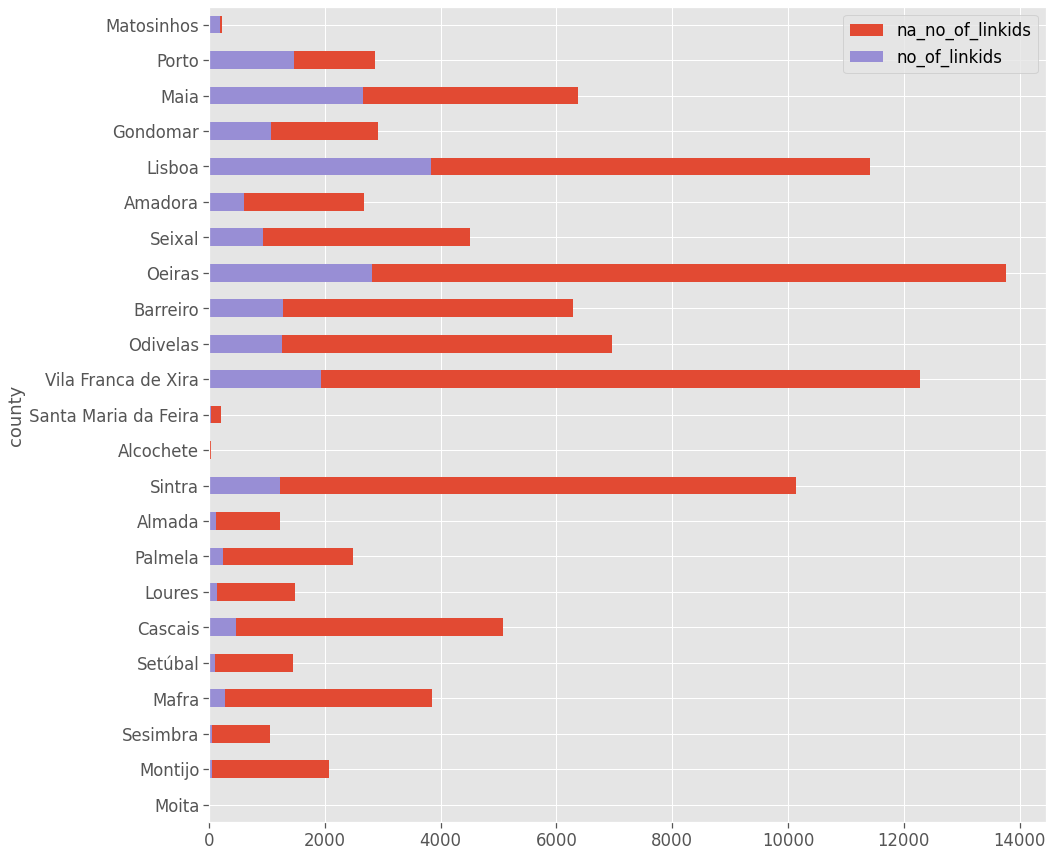

In [ ]:
## counties with linkid and without linkid
ax = both.plot(x="county", y="na_no_of_linkids", kind="barh")
both.plot(x="county", y="no_of_linkids", kind="barh", ax=ax, color="C2", figsize=(15, 15))

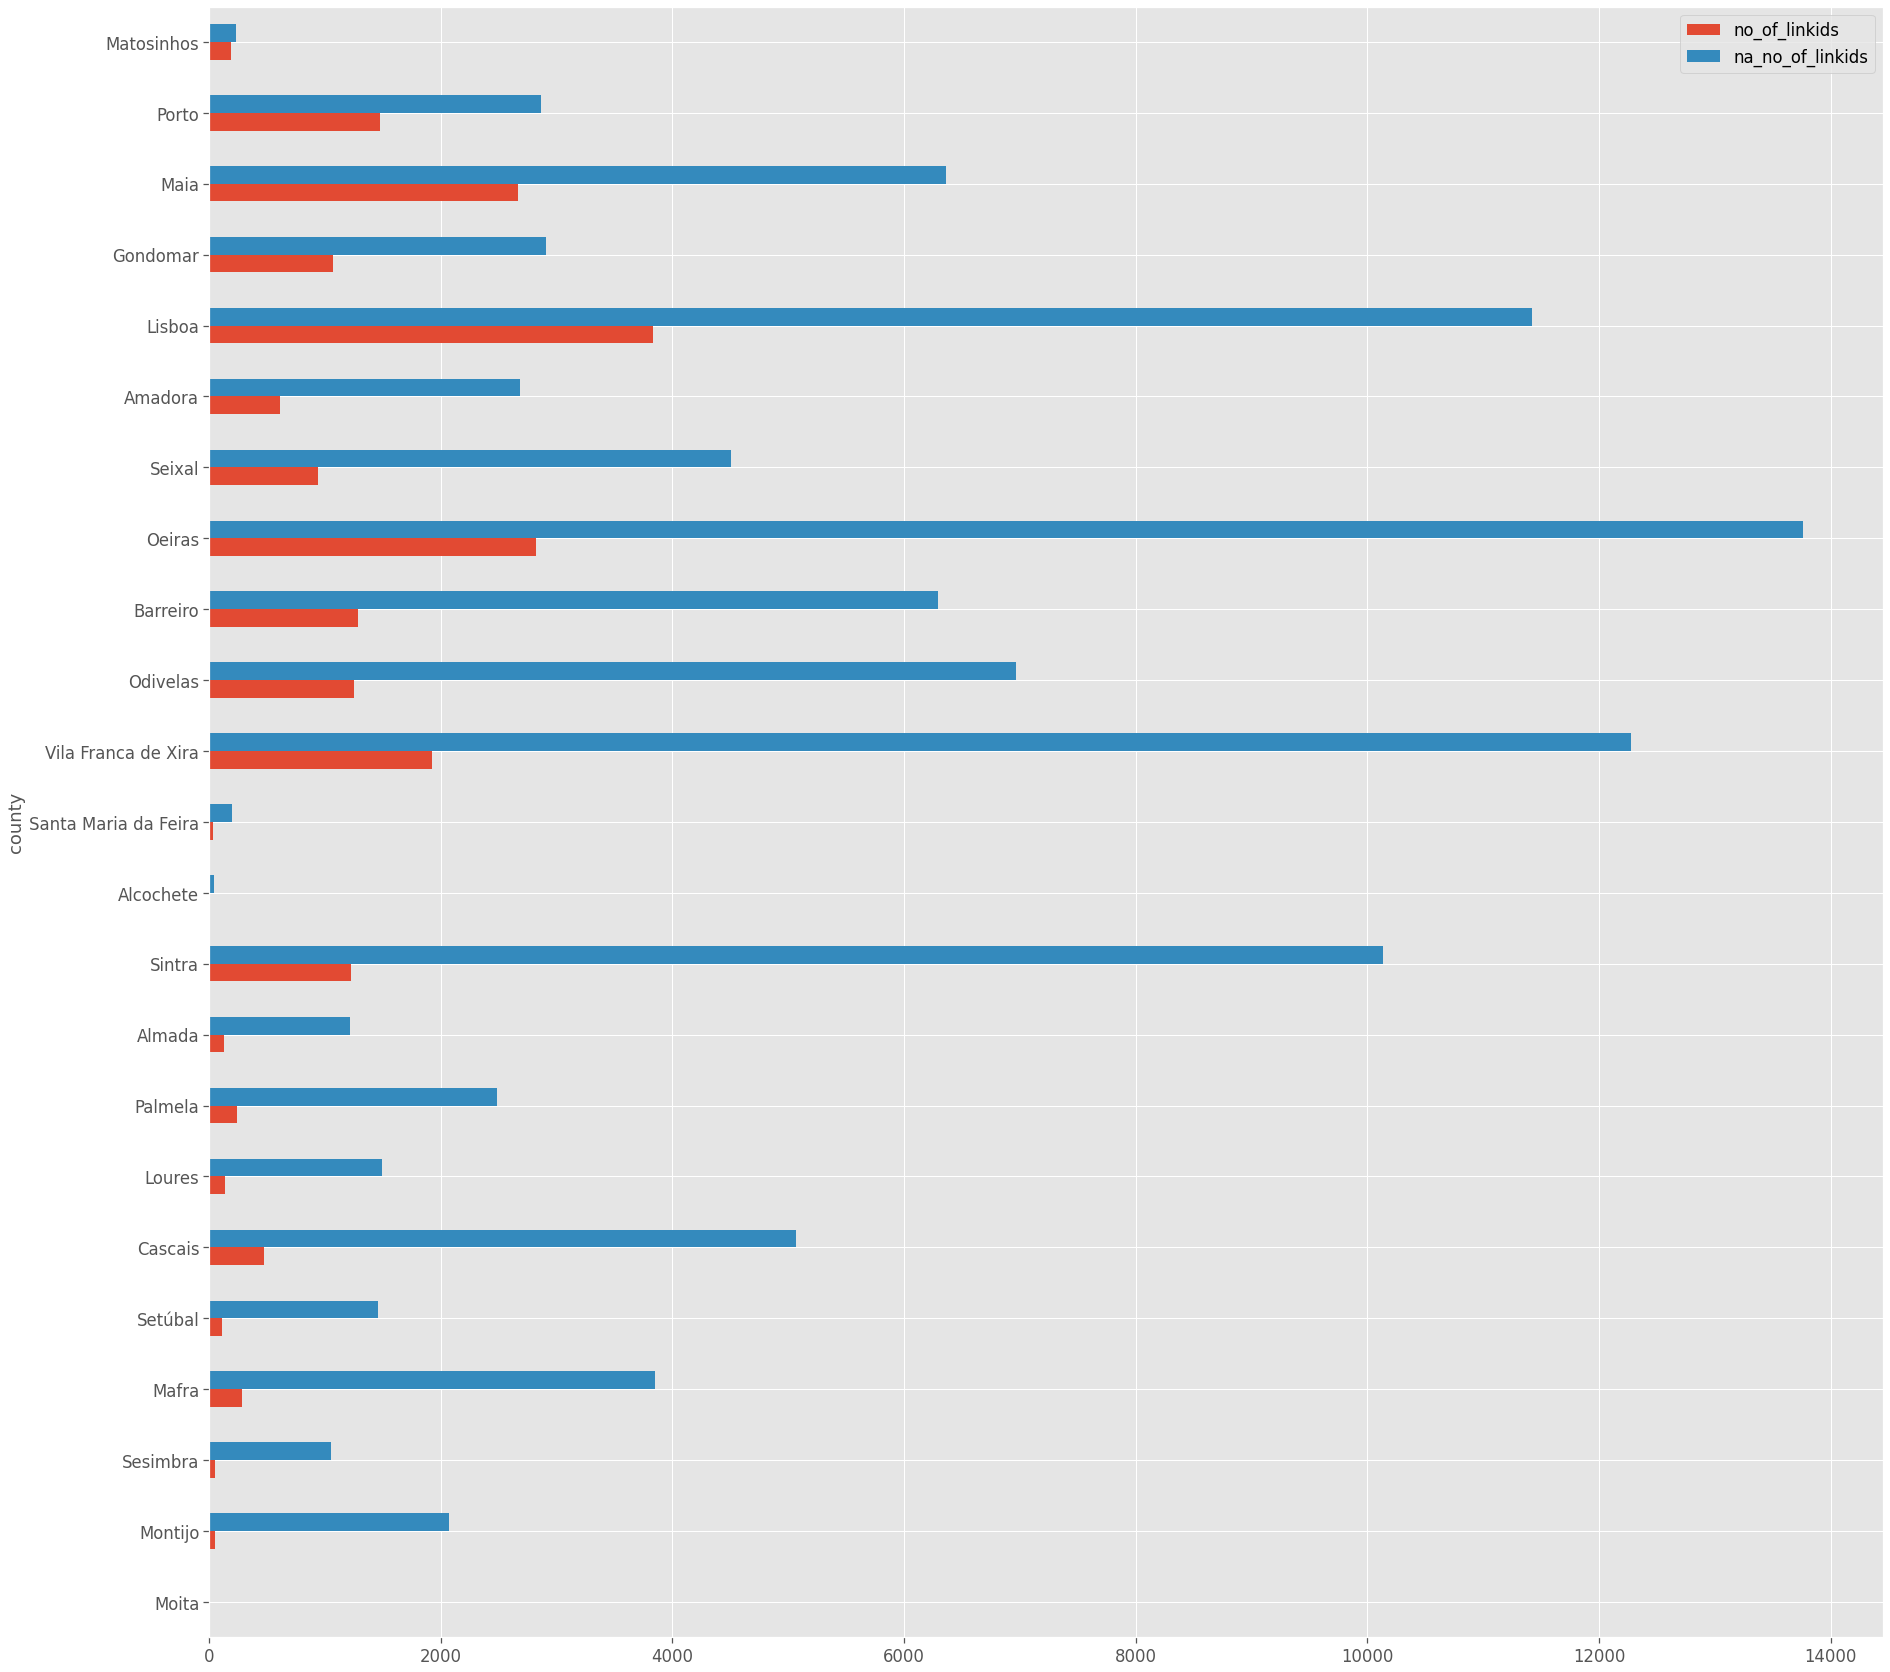

In [ ]:
both.plot(x="county", y=["no_of_linkids", "na_no_of_linkids"], kind="barh", figsize=(30, 30))

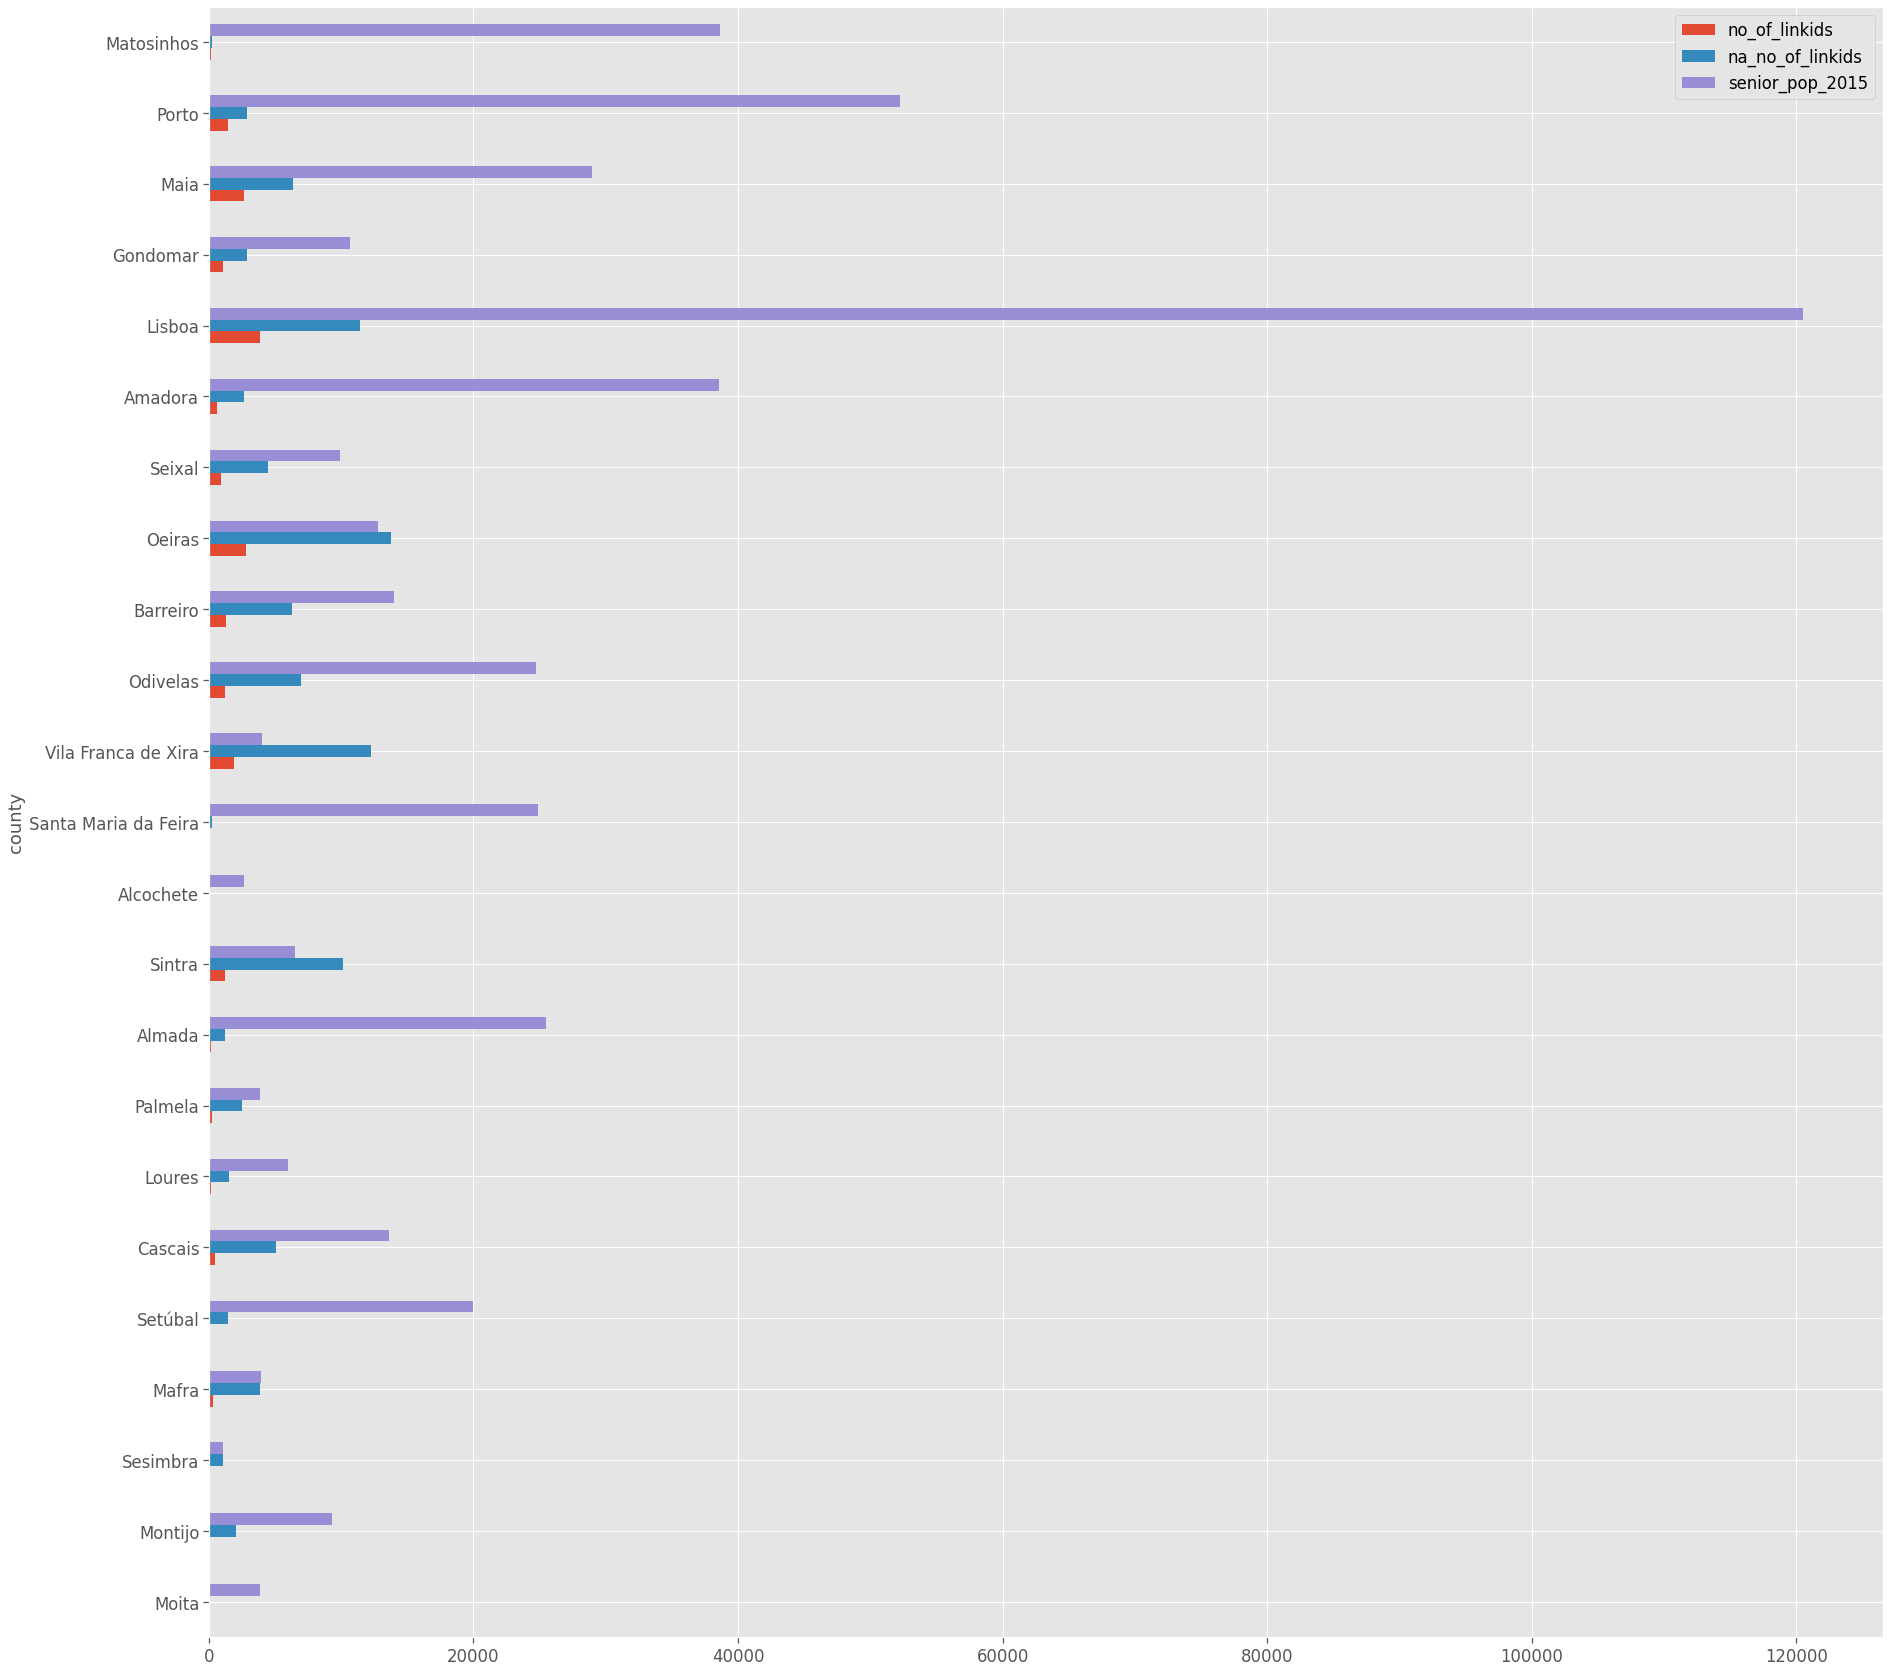

In [ ]:
both.plot(x="county", y=["no_of_linkids", "na_no_of_linkids", "senior_pop_2015"], kind="barh", figsize=(30, 30))

## **Conclusions**
The team really enjoyed working on the mobility challenge for Seniors in Portugal. After many discussions and analyses, the team came up with the conclusion that with some changes to the existing public transportation system, the senior population will be better served.


##### **RESOURCE DISTRIBUTION**
A more optimal distribution of public transportation resources (buses, trains). Based on an optimal distribution of public transportation resources, the under-served counties need a 21% increase in the number of bus routes, which will be offset by 15% coming from overserved counties while keeping the number of bus routes the same. 

If the number of bus routes increase by 15%, then the number of seniors travelling will increase by 8%. 

##### **REVENUE IMPACT**
Assuming 2 trips per seniors on average every week, and 2 euros per trip, the revenue increase will be less than 10%.

## **What other information would be useful to draw a better conclusion**
##### **USER BEHAVIOR**
Having the place of origin is a start but if we are able to determine the place of destination, that would give us a richer analysis. Understanding senior user behavior will be useful in predicting travel patterns that are directly related to the usage of public transportation.

**Daily activities** 
Shopping, running errands, health care

**Leisure Time**
Mental Activities, Cinema, Theatre, Physical activities, country side journeys, gardening

**Religion**
Place of worship

**Involvement in taking care of other older people or children or other voluntary jobs**

##### **OTHER FACTORS**
Looking at the intentions and motivations of seniors also is important for understanding travel behavior. For example: Looking at the technical aspects (built-up infrastructure), convenience (proximity to a bus stop), personal barriers (fears, stamina, attitudes towards novelty eg. Autonomous vehicles), legal (traffic policy, enforcement of speed limits), etc.

### **Scalability and Impact**
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.


### Future Work

- Avaliability of Destination

This will help analyse the traffic intensity of senior population with more granularity and this will help in making more informed recommendations in our analysis to increase elderly mobility.